# Content-Based Recommender System (Cosine Similarity Method)

## Import libraries  and get datasets

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install scikit-learn

In [ ]:
# Import libraries
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Create dataframes from csv
data_dir="/content/drive/MyDrive/Work/Datasets (KMUTNB)"
credits_df = pd.read_csv(os.path.join(data_dir, "credits.csv"))
keywords_df = pd.read_csv(os.path.join(data_dir, "keywords.csv"))
movies_df = pd.read_csv(os.path.join(data_dir, "movies_metadata.csv"))

## Clean and Prepare Data

In [ ]:
# Convert 'id' and 'adult' types
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
movies_df.fillna(-1, inplace=True)
movies_df['id'] = movies_df['id'].astype(np.int64)
movies_df['adult'] = movies_df['adult'].astype(bool)
movies_df['adult'].dtype

dtype('bool')

In [ ]:
movies_df = movies_df.drop(["homepage", "title", "imdb_id", "poster_path", "video", "budget", "revenue", "popularity", "status"], axis=1)
movies_df = movies_df.drop([19730, 29503, 35587])

movies_df.rename(columns={'original_title':'title'}, inplace=True)

movies_df = movies_df.merge(keywords_df, on='id')
movies_df = movies_df.merge(credits_df, on='id')
movies_df["original_language"] = movies_df["original_language"].fillna('')
movies_df["runtime"] = movies_df["runtime"].fillna(0)
movies_df["tagline"] = movies_df["tagline"].fillna('')
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46628 entries, 0 to 46627
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  46628 non-null  bool   
 1   belongs_to_collection  46628 non-null  object 
 2   genres                 46628 non-null  object 
 3   id                     46628 non-null  int64  
 4   original_language      46628 non-null  object 
 5   title                  46628 non-null  object 
 6   overview               46628 non-null  object 
 7   production_companies   46628 non-null  object 
 8   production_countries   46628 non-null  object 
 9   release_date           46628 non-null  object 
 10  runtime                46628 non-null  float64
 11  spoken_languages       46628 non-null  object 
 12  tagline                46628 non-null  object 
 13  vote_average           46628 non-null  float64
 14  vote_count             46628 non-null  float64
 15  ke

In [ ]:
# Convert into List
def clean_regex(names_str, sort=True):
  if isinstance(names_str, str):
    names = re.findall(r"'name': '([^']*)'", names_str)
    if sort == True:
      names.sort()
    return names
  else:
    return []


movies_df['genres'] = movies_df['genres'].fillna('[]').apply(clean_regex)
movies_df['production_companies'] = movies_df['production_companies'].fillna('[]').apply(clean_regex)
movies_df['production_countries'] = movies_df['production_countries'].fillna('[]').apply(clean_regex)
movies_df['spoken_languages'] = movies_df['spoken_languages'].fillna('[]').apply(clean_regex)
movies_df['keywords'] = movies_df['keywords'].fillna('[]').apply(clean_regex)
movies_df['belongs_to_collection'] = movies_df['belongs_to_collection'].fillna('[]').apply(clean_regex)
movies_df['cast'] = movies_df['cast'].fillna('[]').apply(clean_regex, sort=False)
movies_df['crew'] = movies_df['crew'].fillna('[]').apply(clean_regex, sort=False)

movies_df.dropna(inplace=True)

In [ ]:
# Simplify release date
def extract_year(date_str):
  if isinstance(date_str, str):
    year = re.findall(r"\d{4}", date_str)
    if year:
      return year[0]
  return None

movies_df['release_date'] = movies_df['release_date'].apply(extract_year)

In [ ]:
movies_df.head()

,adult,belongs_to_collection,genres,id,original_language,title,overview,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
0,True,[Toy Story Collection],"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",[Pixar Animation Studios],[United States of America],1995,81.0,[English],-1,7.7,5415.0,"[boy, boy next door, friends, friendship, jeal...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[John Lasseter, Joss Whedon, Andrew Stanton, J..."
1,True,[],"[Adventure, Family, Fantasy]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,"[Interscope Communications, Teitler Film, TriS...",[United States of America],1995,104.0,"[English, Français]",Roll the dice and unleash the excitement!,6.9,2413.0,"[board game, disappearance, giant insect, new ...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[Larry J. Franco, Jonathan Hensleigh, James Ho..."
2,True,[Grumpy Old Men Collection],"[Comedy, Romance]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[Lancaster Gate, Warner Bros.]",[United States of America],1995,101.0,[English],Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[best friend, duringcreditsstinger, fishing, o...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[Howard Deutch, Mark Steven Johnson, Mark Stev..."
3,True,[],"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",[Twentieth Century Fox Film Corporation],[United States of America],1995,127.0,[English],Friends are the people who let you be yourself...,6.1,34.0,"[based on novel, chick flick, divorce, interra...","[Whitney Houston, Angela Bassett, Loretta Devi...","[Forest Whitaker, Ronald Bass, Ronald Bass, Ez..."
4,True,[Father of the Bride Collection],[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995,106.0,[English],Just When His World Is Back To Normal... He's ...,5.7,173.0,"[aging, baby, confidence, contraception, daugh...","[Steve Martin, Diane Keaton, Martin Short, Kim...","[Alan Silvestri, Elliot Davis, Nancy Meyers, N..."


## Cosine Similarity System

In [ ]:
cb_movies_df = movies_df.copy()

In [ ]:
R = movies_df['vote_average']
v = movies_df['vote_count']
m = movies_df['vote_count'].quantile(0.6)
C = movies_df['vote_average'].mean()

cb_movies_df['weighted_score'] = (R*v + C*m)/(v+m)
cb_movies_df['weighted_score']

0        7.694230
1        6.892038
2        6.375396
3        5.950355
4        5.692912
           ...   
46623    5.510463
46624    6.175967
46625    5.093686
46626    5.611161
46627    5.611161
Name: weighted_score, Length: 46628, dtype: float64

In [ ]:
scaler = MinMaxScaler()
cb_movies_df['weighted_score'] = scaler.fit_transform(cb_movies_df[['weighted_score']])
cb_movies_df['weighted_score'].head()

0    0.831204
1    0.729269
2    0.663619
3    0.609608
4    0.576895
Name: weighted_score, dtype: float64

In [ ]:
major_contents = ['adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'cast', 'crew']
minor_contents = ['belongs_to_collection', 'original_language', 'production_countries', 'release_date', 'runtime', 'spoken_languages']

In [ ]:
def concatenate(row, contents):
  text = ''
  for content in contents:
    value = row[content]
    if isinstance(value, list): # Transform List into String
      text += ' '.join(map(str, value)) + ' '
    elif pd.isna(value): # Manage null values
      text += ''
    else: # Manage other cases
      text += str(value) + ' '
  return text.strip()

In [ ]:
cb_movies_df['major_bag'] = cb_movies_df.apply(concatenate, axis=1, contents=major_contents)
cb_movies_df['minor_bag'] = cb_movies_df.apply(concatenate, axis=1, contents=minor_contents)

cb_content_df = cb_movies_df[['title', 'weighted_score', 'major_bag', 'minor_bag']]

In [ ]:
cb_content_df = cb_content_df.sort_values(by='weighted_score', ascending=False)
cb_content_df = cb_content_df.head(10000)

In [ ]:
cb_content_df.head()

,title,weighted_score,major_bag,minor_bag
10397,Dilwale Dulhania Le Jayenge,9.022585,"True Comedy Drama Romance Raj is a rich, caref...",hi India 1995 190.0 हिन्दी
44485,Planet Earth II,8.602576,True Documentary David Attenborough presents a...,en France Germany United Kingdom 2016 300.0 En...
40253,Planet Earth,8.549568,True Documentary A documentary miniseries desc...,en Japan United Kingdom United States of Ameri...
314,The Shawshank Redemption,8.494825,True Crime Drama Framed in the 1940s for the d...,en United States of America 1994 142.0 English
841,The Godfather,8.492825,True Crime Drama Spanning the years 1945 to 19...,The Godfather Collection en United States of A...


In [ ]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix_1 = tfidf.fit_transform(cb_content_df['major_bag'])
tfidf_matrix_2 = tfidf.fit_transform(cb_content_df['minor_bag'])

In [ ]:
cos_sim_1 = cosine_similarity(tfidf_matrix_1)
cos_sim_2 = cosine_similarity(tfidf_matrix_2)

In [ ]:
def predict(title, similarity_weight=0.75, major_weight=0.75, number=5):
  data = cb_content_df.reset_index()
  index_movie = data[data['title'] == title].index
  similarity_major = cos_sim_1[index_movie].T
  similarity_minor = cos_sim_2[index_movie].T
  similarity = major_weight * similarity_major + (1 - major_weight) * similarity_minor

  sim_df = pd.DataFrame(similarity, columns=['similarity'])
  cb_final_df = pd.concat([data, sim_df], axis=1)
  cb_final_df['final_score'] = similarity_weight * cb_final_df['similarity'] + (1 - similarity_weight) * cb_final_df['weighted_score']

  cb_final_df = cb_final_df[cb_final_df['title'] != title]
  cb_final_df = cb_final_df.sort_values(by='final_score', ascending=False).head(number)
  cb_final_df.set_index('title', inplace=True)
  print(cb_final_df[['weighted_score', 'similarity', 'final_score']])
  return cb_final_df[['weighted_score', 'similarity', 'final_score']]

In [ ]:
results_1 = predict('Star Wars', similarity_weight=1.00, major_weight=0.75, number=10)
results_2 = predict('Star Wars', similarity_weight=0.75, major_weight=0.75, number=10)

                                                    weighted_score  \
title                                                                
The Empire Strikes Back                                   8.193542   
Return of the Jedi                                        7.892814   
Star Wars: Episode III - Revenge of the Sith              7.094702   
Star Wars: Episode I - The Phantom Menace                 6.397394   
Star Wars: Episode II - Attack of the Clones              6.397106   
Star Wars: The Force Awakens                              7.496462   
Rogue One: A Star Wars Story                              7.394765   
Robot Chicken: Star Wars                                  6.635170   
Empire of Dreams: The Story of the Star Wars Tr...        6.496416   
Raiders of the Lost Ark                                   7.692096   

                                                    similarity  final_score  
title                                                                        
The

In [ ]:
def plot_results(df, similarity):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['similarity'], df['final_score'], alpha=0.5, c='blue', label='Final Score vs Similarity')
    for i, row in df.iterrows():
        plt.annotate(row.name, (row['similarity'], row['final_score']), fontsize=9, alpha=0.75)
    plt.xlabel('Similarity')
    plt.ylabel('Final Score')
    plt.title('Final Score vs Similarity ({})'.format(similarity))
    plt.legend()
    plt.grid(True)
    plt.show()


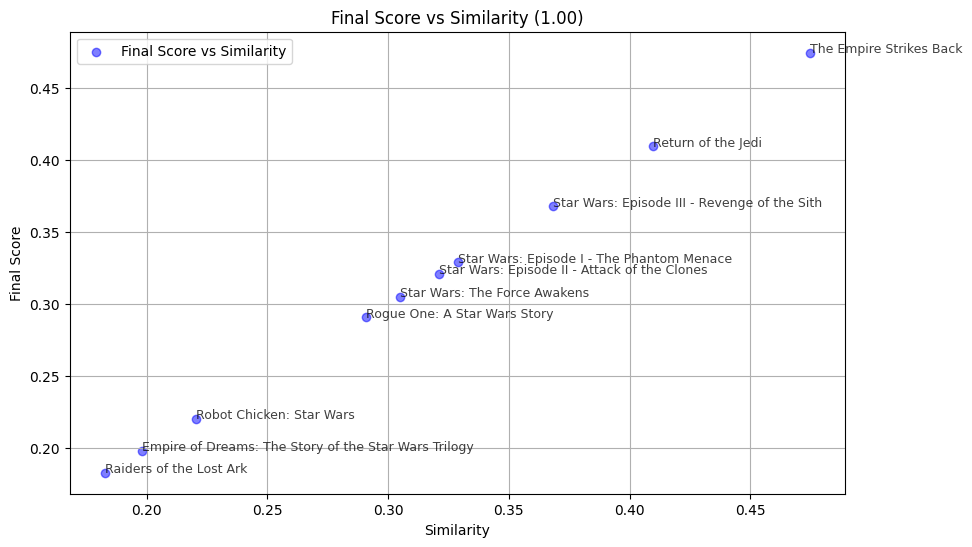

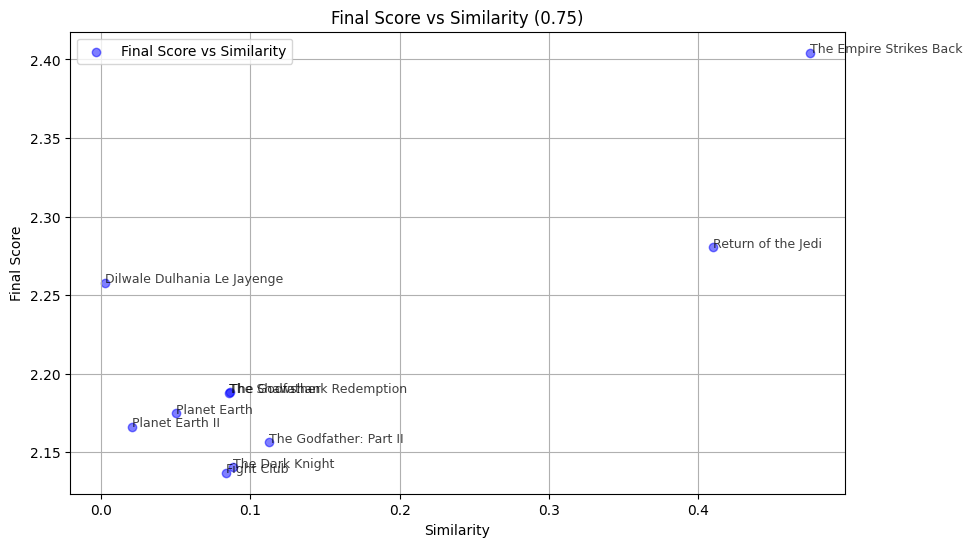

In [ ]:
plot_results(results_1, "1.00")
plot_results(results_2, "0.75")